In this notebook we use Quantum State Tomography (QST) to obtain fidelities of ZZ(θ) interactions, using:

1. a standard decomposition using 2 CNOTs
2. an optimized decomposition using only one Cross Resonance (CR(θ))

In both implementations, the CR pulses are echoed.

The state on which we do tomography is produced by a ZZ(θ) sandwiched between hadmards
```
        ┌───┐        ┌───┐
q_0: |0>┤ H ├─■──────┤ H ├
        ├───┤ │zz(θ) ├───┤
q_1: |0>┤ H ├─■──────┤ H ├
        └───┘        └───┘
```

when starting at |00>, this simplifies to the following:
```
                 ┌───┐
q_0: |0>─────────┤ X ├
        ┌───────┐└─┬─┘
q_1: |0>┤ Rx(θ) ├──■──
        └───────┘
```

which causes the |00> and |11> basis states to track each other in a sinusoid:
```
|Ⲯ> = exp(θ/2)|00> + exp(π/2-θ/2)|11>
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import IBMQ, pulse, schedule, transpile, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.pulse import pulse_lib as pulse_library, reschedule
from qiskit.ignis.measurement.discriminator.iq_discriminators import LinearIQDiscriminator
from qiskit.ignis.measurement.discriminator.filters import DiscriminationFilter
import qiskit.ignis.mitigation.measurement as mit
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography.basis import PauliBasis
from qiskit.visualization.state_visualization import plot_state_city
from qiskit.quantum_info import state_fidelity
from qiskit.circuit import Gate
from qiskit.scheduler import schedule_circuit, ScheduleConfig
from qiskit.quantum_info import state_fidelity, process_fidelity

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
config = backend.configuration()
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [6]:
thetas = np.linspace(0, np.pi/2, 21, endpoint=True)
print(thetas)

[0.         0.07853982 0.15707963 0.23561945 0.31415927 0.39269908
 0.4712389  0.54977871 0.62831853 0.70685835 0.78539816 0.86393798
 0.9424778  1.02101761 1.09955743 1.17809725 1.25663706 1.33517688
 1.41371669 1.49225651 1.57079633]


In [7]:
sine_schedules_std = []
sine_schedules_opt = []

In [8]:
## Standard Way: Cnot RZ Cnot
for theta in thetas:
    circuit = q.QuantumCircuit(2)
    circuit.h(0)
    circuit.h(1)
    circuit.cx(0, 1)
    circuit.rz(theta, 1)
    circuit.cx(0, 1)
    circuit.h(0)
    circuit.h(1)

    decomposed_circuit = circuit.decompose()

    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
    sine_schedules_std.append(schedule)

In [9]:
## Optimized Way: zz_interaction decomposes directly to cross resonance for theta in thetas:
for theta in thetas:
    circuit = q.QuantumCircuit(2)
    circuit.h(0)
    circuit.h(1)
    circuit.zz_interaction(theta, 0, 1)
    circuit.h(0)
    circuit.h(1)

    decomposed_circuit = circuit.decompose()

    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=0)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)    
    sine_schedules_opt.append(schedule)

### Set up State Tomography

In [10]:
def qst_circuits_and_schedules(schedule, theta):
    """
    create the state tomography circuits
    the state preparation circuit is (H $otimes$ H).ZZ.(H $otimes$ H)
    """
    num_qubits = 2
    qubit_pair = [0, 1]
    qr = QuantumRegister(num_qubits)
    my_gate = Gate(name='sinusoid_{}'.format(theta), num_qubits=num_qubits, params=[])

    # create the tomography circuits
    qc = QuantumCircuit(qr)
    qc.append(my_gate, qr[:])
    qst_circuits = state_tomography_circuits(qc, measured_qubits=qr)

    # transpile so that the singles are in terms of the u gates
    qst_circuits = transpile(qst_circuits, backend, initial_layout=qubit_pair,
                             basis_gates=['u1','u2','u3',my_gate.name])

    # add the custom gate to the cmd def
    cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
    cmd_def.add(my_gate.name, qubits=qubit_pair, schedule=schedule)

    # schedule!
    schedule_config = ScheduleConfig(cmd_def, meas_map=backend.configuration().meas_map)
    qst_schedules = [schedule_circuit(circ, schedule_config) for circ in qst_circuits]
    
    return qst_circuits, qst_schedules

In [11]:
tomo_circuits_std = []
tomo_schedules_std = []
for sine_schedule, theta in zip(sine_schedules_std, thetas):
    tomo_circs, tomo_scheds = qst_circuits_and_schedules(sine_schedule, theta)
    tomo_circuits_std.append(tomo_circs)
    tomo_schedules_std.append(tomo_scheds)
    
tomo_circuits_opt = []
tomo_schedules_opt = []
for sine_schedule, theta in zip(sine_schedules_opt, thetas):
    tomo_circs, tomo_scheds = qst_circuits_and_schedules(sine_schedule, theta)
    tomo_circuits_opt.append(tomo_circs)
    tomo_schedules_opt.append(tomo_scheds)

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:399: UserWarning: The control channel appropriate for an interaction should be determined from the hamiltonian. This will be determined for you in the future.
  warnings.warn("The control channel appropriate for an interaction should be determined "


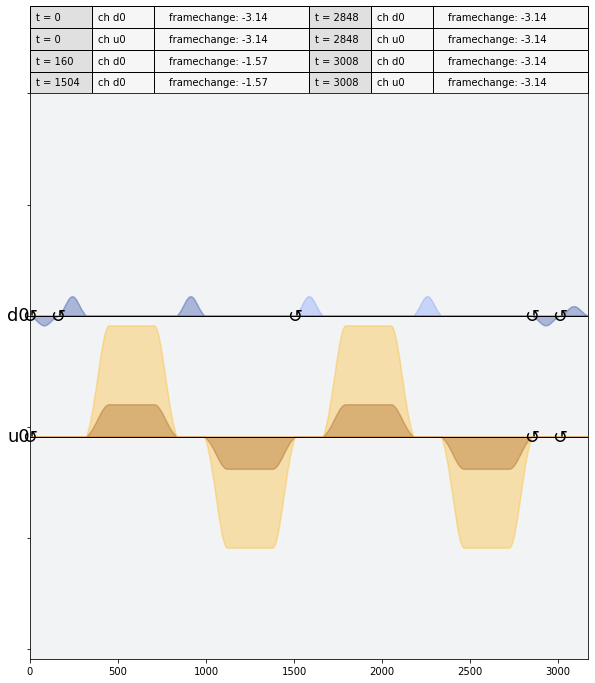

In [12]:
tomo_schedules_std[0][0].filter(channels=[config.drive(0), config.control(0)]).draw()

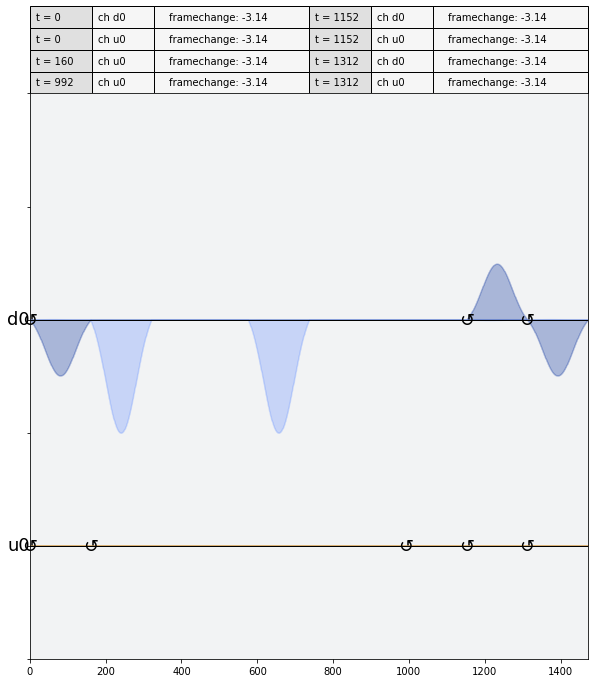

In [13]:
tomo_schedules_opt[0][0].filter(channels=[config.drive(0), config.control(0)]).draw()

### Run tomo experiments

In [14]:
import itertools
flat_schedules_std = list(itertools.chain(*tomo_schedules_std))
flat_schedules_opt = list(itertools.chain(*tomo_schedules_opt))

In [15]:
shots = 2000
job_std = q.execute(flat_schedules_std, backend=backend, shots=shots)
job_opt = q.execute(flat_schedules_opt, backend=backend, shots=shots)
print('job_std is %s' % job_std.job_id())
print('job_opt is %s' % job_opt.job_id())

/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


job_std is 5dd98e23fa67c10018cebb23
job_opt is 5dd98e46af2f73001805ddc0


In [35]:
job_std.status()

<JobStatus.DONE: 'job has successfully run'>

In [37]:
job_opt.status()

<JobStatus.RUNNING: 'job is actively running'>

### Run a mitigation cal job

In [17]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1])
meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)
job_mit = q.execute(meas_schedules, backend)

In [19]:
job_mit.status()

<JobStatus.QUEUED: 'job is queued'>

-----
### Fit tomography data to get statevector

In [38]:
from qiskit.result import marginal_counts

In [39]:
result_std = job_std.result()
result_opt = job_opt.result()

In [40]:
# mitigate results
result_mit = marginal_counts(job_mit.result(), [0,1])
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

array([[0.95703125, 0.09082031, 0.06347656, 0.00683594],
       [0.02832031, 0.88867188, 0.00390625, 0.06542969],
       [0.01367188, 0.00292969, 0.91308594, 0.10058594],
       [0.00097656, 0.01757812, 0.01953125, 0.82714844]])

In [41]:
result_std_marg = marginal_counts(result_std, [0,1])
result_opt_marg = marginal_counts(result_opt, [0,1])

In [42]:
from copy import deepcopy
result_cpy_std = deepcopy(result_std_marg)
result_cpy_opt = deepcopy(result_opt_marg)

In [43]:
standard_statevectors = []
optimized_statevectors = []

for i, theta in enumerate(thetas):
    result_std_mit = readout_fitter.filter.apply(result_cpy_std)
    result_opt_mit = readout_fitter.filter.apply(result_cpy_opt)
    
    # remove results for other thetas
    # TODO: allow selecting subset of result
    single_qst_size = len(tomo_schedules_std[0])
    del result_std_mit.results[:i*single_qst_size]
    del result_std_mit.results[single_qst_size:]
    del result_opt_mit.results[:i*single_qst_size]
    del result_opt_mit.results[single_qst_size:]
    assert len(result_std_mit.results) == single_qst_size
    assert len(result_opt_mit.results) == single_qst_size

    qst_fitter = StateTomographyFitter(result_std_mit, tomo_circuits_std[i])
    sv = qst_fitter.fit(method='cvx')
    standard_statevectors.append(sv)
    
    qst_fitter = StateTomographyFitter(result_opt_mit, tomo_circuits_opt[i])
    sv = qst_fitter.fit(method='cvx')
    optimized_statevectors.append(sv)

## Analysis

### plot fidelities

In [44]:
# what are the ideal statevectors
from qiskit.quantum_info.states import Statevector
ideal_statevectors = []
for theta in thetas:
    circuit = QuantumCircuit(2)
    circuit.h(0)
    circuit.h(1)
    circuit.rzz(theta, 0, 1)
    circuit.h(0)
    circuit.h(1)
    ideal = Statevector.from_instruction(circuit).data
    ideal_statevectors.append(ideal)

In [45]:
standard_fidelities = []
for sv1, sv2 in zip(standard_statevectors, ideal_statevectors):
    fidelity = state_fidelity(sv1, sv2)
    standard_fidelities.append(fidelity)
    
optimized_fidelities = []
for sv1, sv2 in zip(optimized_statevectors, ideal_statevectors):
    fidelity = state_fidelity(np.abs(sv1), np.abs(sv2))
    optimized_fidelities.append(fidelity)

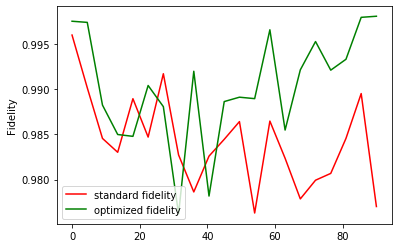

In [46]:
plt.plot(thetas * 180 / np.pi, standard_fidelities, 'r')
plt.plot(thetas * 180 / np.pi, optimized_fidelities, 'g')
plt.ylabel('Fidelity')
plt.legend(['standard fidelity', 'optimized fidelity'])

In [47]:
np.mean(standard_fidelities)

0.9842031722855742

In [48]:
np.mean(optimized_fidelities)

0.9902281974126768

### plot the sinusoidal P(00) and P(11)

In [49]:
ideal_00_prob = [abs(sv[0])**2 for sv in ideal_statevectors]
ideal_11_prob = [abs(sv[-1])**2 for sv in ideal_statevectors]
std_00_prob = [sv[0][0]*sv[0][0].conjugate() for sv in standard_statevectors]  # these are actually density matrices not statevectors
std_11_prob = [sv[-1][-1].real for sv in standard_statevectors]
opt_00_prob = [sv[0][0].real for sv in optimized_statevectors]
opt_11_prob = [sv[-1][-1].real for sv in optimized_statevectors]

/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


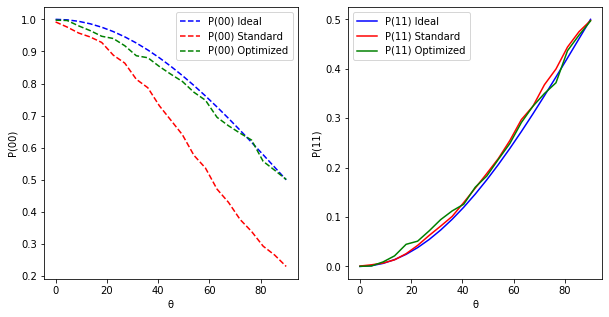

In [50]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(thetas * 180 / np.pi, ideal_00_prob, 'b--')
plt.plot(thetas * 180 / np.pi, std_00_prob, 'r--')
plt.plot(thetas * 180 / np.pi, opt_00_prob, 'g--')
plt.xlabel('θ')
plt.ylabel('P(00)')
plt.legend(['P(00) Ideal', 'P(00) Standard', 'P(00) Optimized'])

plt.subplot(122)
plt.plot(thetas * 180 / np.pi, ideal_11_prob, 'b')
plt.plot(thetas * 180 / np.pi, std_11_prob, 'r')
plt.plot(thetas * 180 / np.pi, opt_11_prob, 'g')
plt.xlabel('θ')
plt.ylabel('P(11)')
plt.legend(['P(11) Ideal', 'P(11) Standard', 'P(11) Optimized'])